# Machine Learning flow rule from micromechanical data

Demonstration of training and application of machine learning flow rule in Finite Element Analysis. Uses pyLabFEA package. For details of Machine Learning (ML) flow rules see the article by A. Hartmaier "Data-Oriented Constitutive Modeling of Plasticity in Metals" Materials 2020, 13(7), 1600. This open access article is available <a rel="preprint" href="https://www.mdpi.com/1996-1944/13/7/1600#">here</a>.

Author: Alexander Hartmaier, ICAMS, Ruhr-Universtität Bochum, April 2020

## Read and pre-process micromechanical data

Read input data produced from micromechanical simulations and plot equiv. stress vs. equiv. total strain for individual load cases and filtered raw data of eqiv. stresses around critical equiv. plastic strain vs. polar angle. 


*** Microstructure: texture1 ***
41115  data points imported into database  Dataset
Number of load cases:  359
Estimated elasic constants: E=79.92 GPa, nu=0.30
Estimated yield strength: 38.80 MPa, from 2020 data sets with PEEQ approx. 0.002


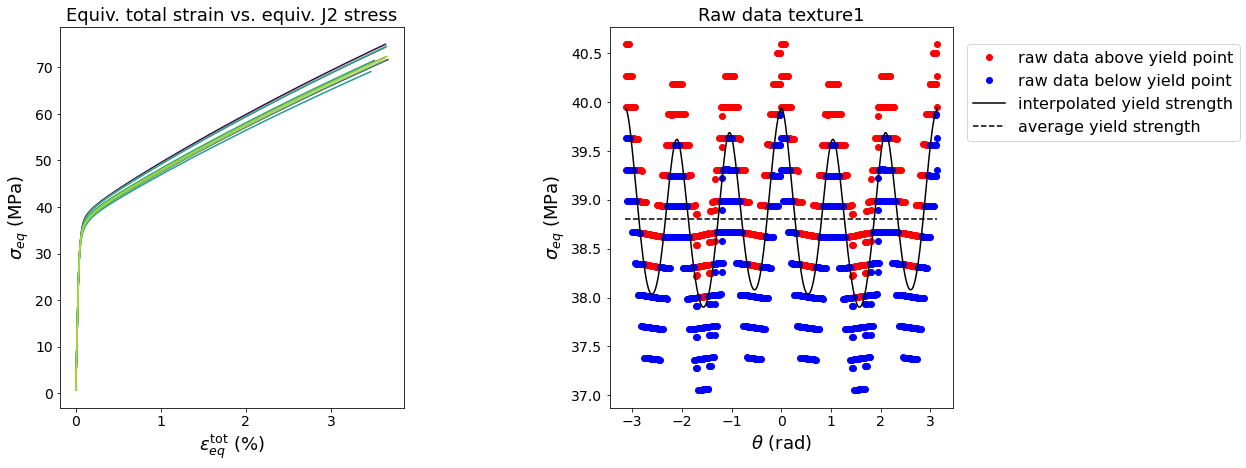


*** Microstructure: texture2 ***
36859  data points imported into database  Dataset
Number of load cases:  359
Estimated elasic constants: E=133.33 GPa, nu=0.30
Estimated yield strength: 45.70 MPa, from 1754 data sets with PEEQ approx. 0.002


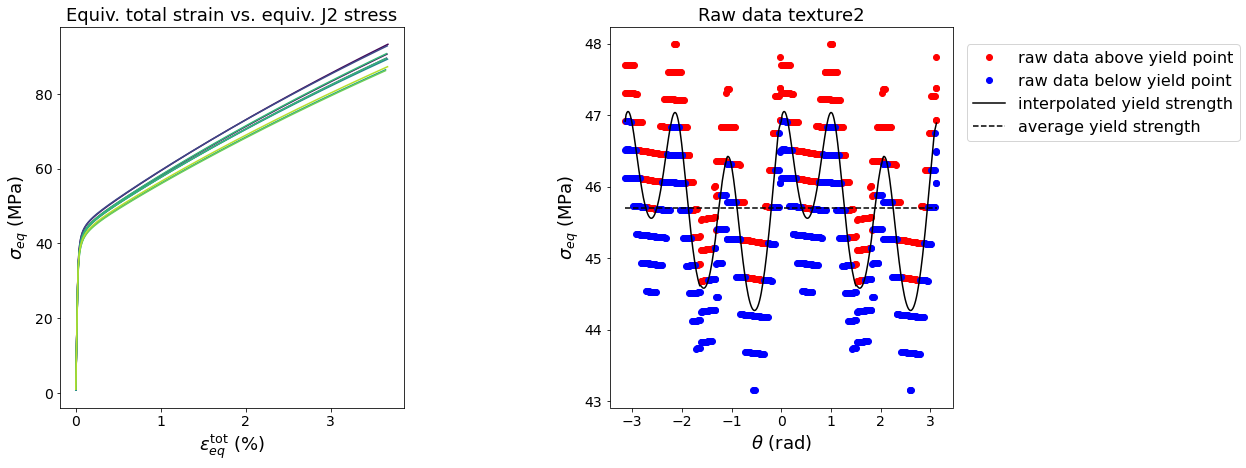


*** Microstructure: texture3 ***
41827  data points imported into database  Dataset
Number of load cases:  359
Estimated elasic constants: E=133.72 GPa, nu=0.30
Estimated yield strength: 45.83 MPa, from 2048 data sets with PEEQ approx. 0.002


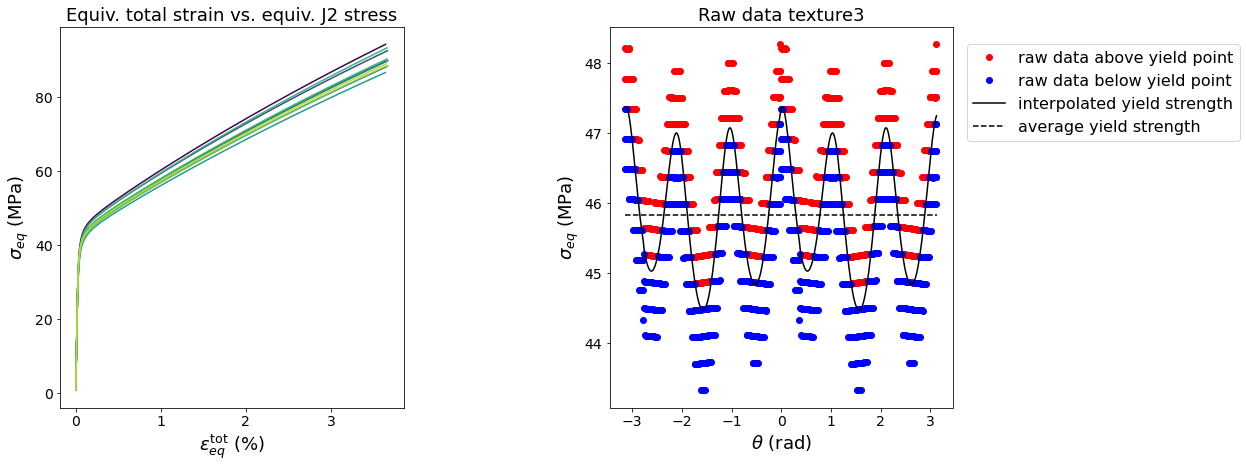


*** Microstructure: texture4 ***
41611  data points imported into database  Dataset
*** Warning: Large hydrostatic stresses: minimum p= 0.00 MPa, maximum p= 1.07 MPa
Number of load cases:  361
Estimated elasic constants: E=154.36 GPa, nu=0.30
Estimated yield strength: 48.65 MPa, from 2052 data sets with PEEQ approx. 0.002


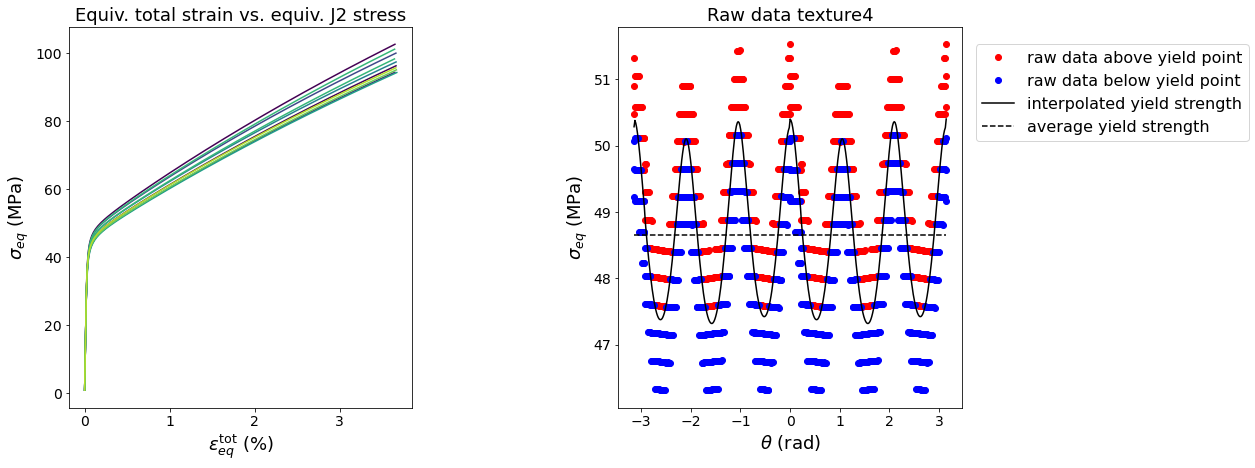

In [1]:
import sys
import pylabfea as FE
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

'set path truncs and open JSON file'
path_data='/Users/alexander/Data/'
path_json='./Data/JSON/'
msl = ['texture1', 'texture2', 'texture3', 'texture4']

'import data sets for specified texture files and provide graphical output'
data = FE.Data(msl, path_data, path_json, epl_crit=0.002, npe=5, plot=True) 

Plot yield loci of imported microstructures

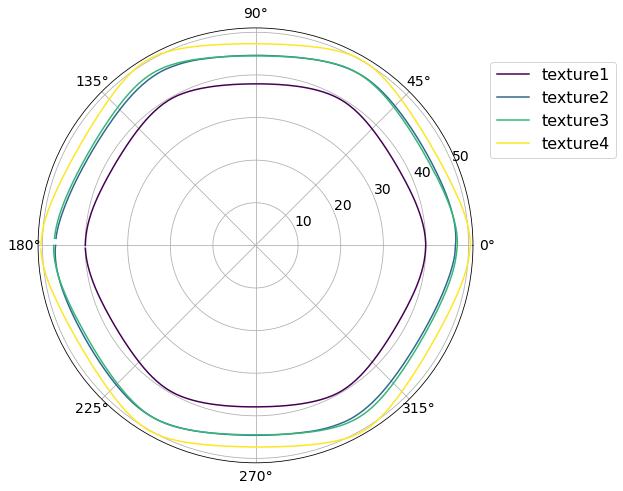

In [2]:
data.plot_yield_locus('texture')

Yield loci at all levels of work hardening for texture1


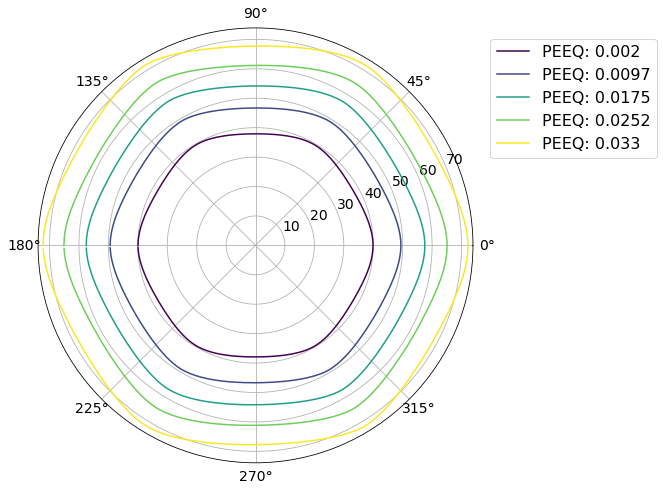

Yield loci at all levels of work hardening for texture2


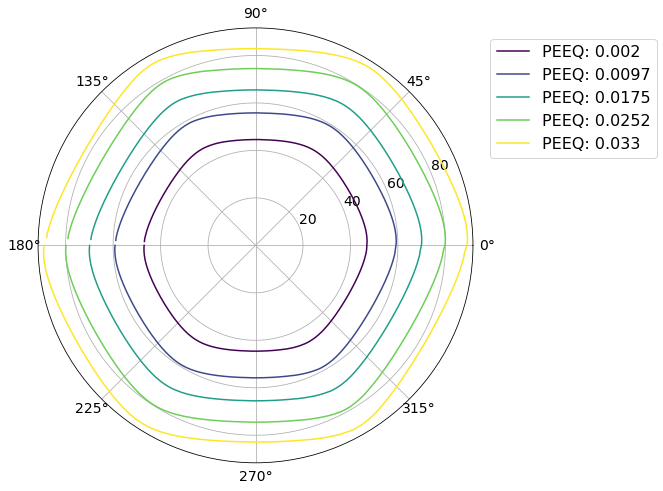

Yield loci at all levels of work hardening for texture3


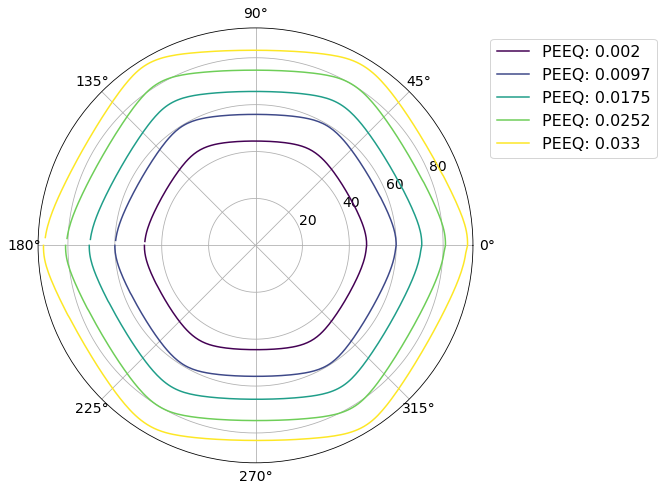

Yield loci at all levels of work hardening for texture4


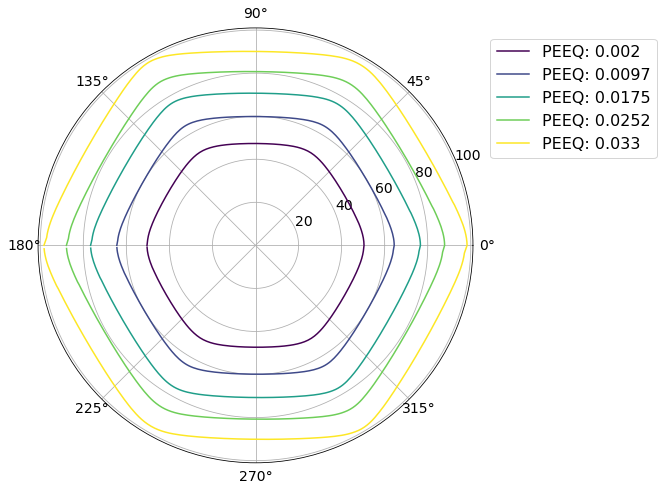

In [3]:
for i in range(data.Nset):
    print('Yield loci at all levels of work hardening for',data.mat_param['ms_name'][i])
    data.plot_yield_locus('work_hard', set_ind=i)

## Train ML yield function for all microstructures.

In [21]:
'define material as basis for ML flow rule'
mat_ml = FE.Material(name='ML-all')  # define material 
mat_ml.elasticity(E=data.E_av, nu=data.nu_av)  # assign average properties to material
mat_ml.plasticity(sy=data.sy_av)               # assessed from data
mat_ml.microstructure(data.mat_param)                    # define microstructural parameters for material
#mat_ml.set_microstructure('texture', 1)        # define texture as active microstructural parameter, with current value 1

'train SVC with data from all microstructures'
mat_ml.train_SVC(C=18, gamma=3.5, plot=False)


---------------------------

SVM classification training
---------------------------

386640 training data sets created from 4 microstructures, with 5 flow stresses in 358 load cases
Using cyclindrical stresses for training
Using work hardening data for training: 5 data sets up to PEEQ= 0.033
Using texture data for training: 4 data sets with texture_parameters in range [1.00,4.00]
SVC(C=18, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=3.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Training set score: 99.20450019912386 %


Reference yield strength: 44.75 MPa (=average yield strength of all microstructures)
Yield strengths of individual datasets (MPa):  [38.8, 45.7, 45.83, 48.65]
Averaged yield strengths in microstructure definition:  [38.8, 45.7, 45.83, 48.63] MPa
Black lines refer to reference flow stress obtained from data.


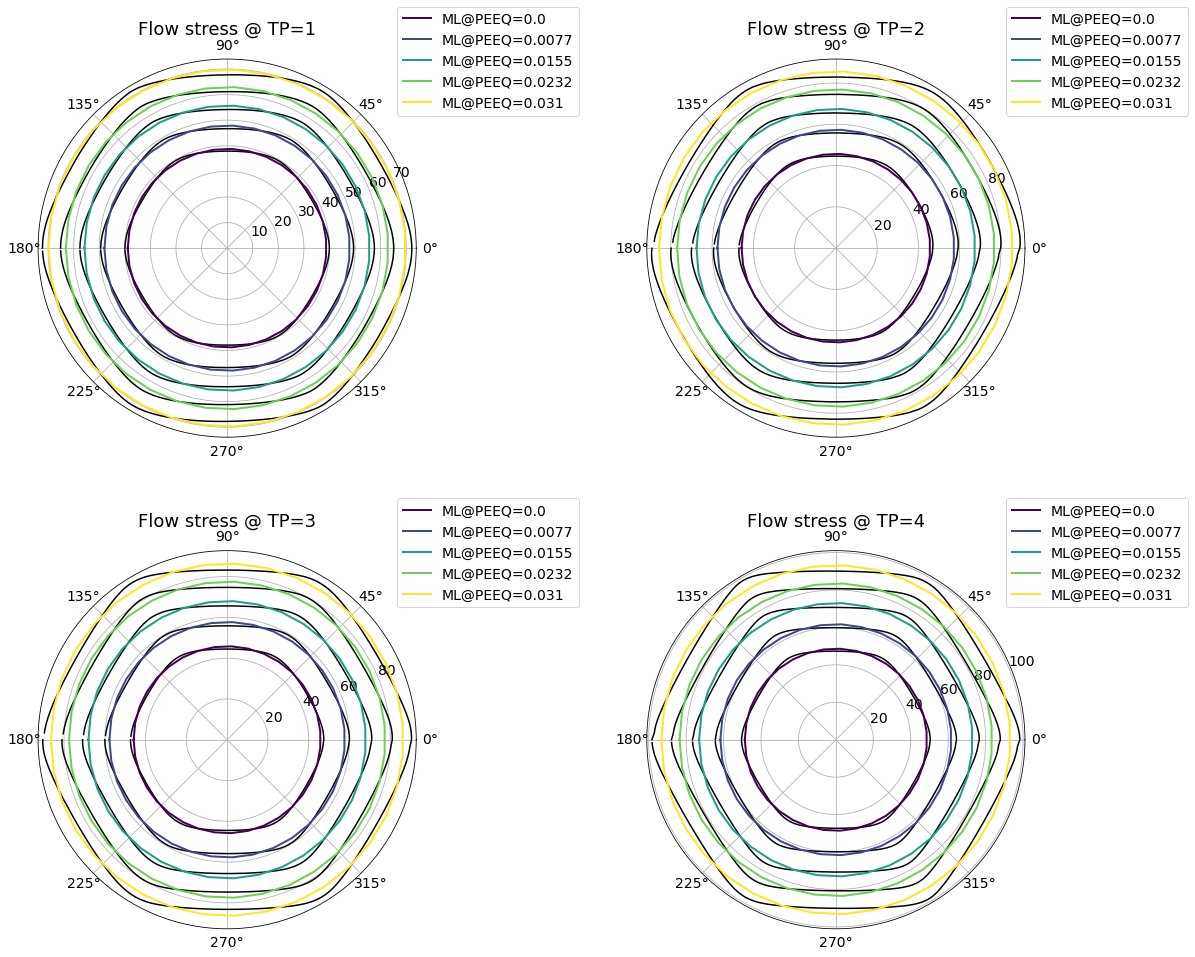

In [22]:
import matplotlib as mpl

'plot result of training'
Npl   = mat_ml.msparam['Npl'] 
Ntext = mat_ml.msparam['Ntext']
ncol = 2
nrow = int(Ntext/ncol + 0.95)
cmap = mpl.cm.get_cmap('viridis', 10)
fig  = plt.figure(figsize=(20, 8*nrow))
plt.subplots_adjust(hspace=0.3)
epc   = mat_ml.msparam['epc']
scale = mat_ml.msparam['work_hard'][-1] - epc
theta = np.linspace(-np.pi,np.pi,36)
print('Reference yield strength:', mat_ml.sy.round(decimals=2), 'MPa (=average yield strength of all microstructures)')
print('Yield strengths of individual datasets (MPa): ',[set.sy.round(decimals=2) for set in data.set])
print('Averaged yield strengths in microstructure definition: ',
      [mat_ml.msparam['flow_seq_av'][i,0].round(decimals=2) for i in range(Ntext)],'MPa')
print('Black lines refer to reference flow stress obtained from data.')
for k in range(Ntext):
    mat_ml.set_microstructure('texture', mat_ml.msparam['texture'][k])
    ax = plt.subplot(nrow, ncol, k+1, projection='polar')
    for j in range(Npl):
        peeq = mat_ml.msparam['work_hard'][j] - epc
        mat_ml.set_workhard(peeq)
        syc = mat_ml.msparam['flow_stress'][k,j,:,:]
        plt.polar(syc[:,1], syc[:,0], '-k')
        'ML yield fct: find norm of princ. stess vector lying on yield surface'
        snorm = FE.sp_cart(np.array([mat_ml.sflow*np.ones(36), theta]).T)
        x1 = fsolve(mat_ml.find_yloc, np.ones(36), args=snorm, xtol=1.e-5)
        sig = snorm*np.array([x1,x1,x1]).T
        s_yld = FE.seq_J2(sig)
        plt.polar(theta, s_yld, '-k', color=cmap(peeq/scale), 
                  label='ML@PEEQ='+str(peeq.round(decimals=4)), linewidth=2)
        plt.title('Flow stress @ TP='+str(mat_ml.msparam['texture'][k].round(decimals=2)), fontsize=18)
        plt.legend(loc=(.95,0.85),fontsize=14)
        plt.tick_params(axis="x",labelsize=14)
        plt.tick_params(axis="y",labelsize=14)
plt.show()

## Create arbitrary texture parameters and apply ML flow rule for FEA of mechanical properties.



====== Texture Parameter 1.0 ======
Yield locus for microstructure with interpolated yield strength 38.8 MPa
Blue line: Yield locus of isotropic J2 material with yield strength 44.75 MPa


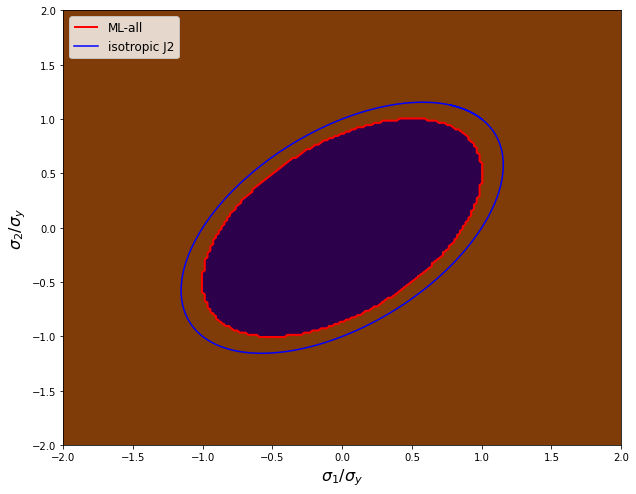

Stress-Strain-Curves
---------------------------------------------------------
J2 yield stress under uniax-x loading: 38.807 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 38.808 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 38.808 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 38.814 MPa
---------------------------------------------------------


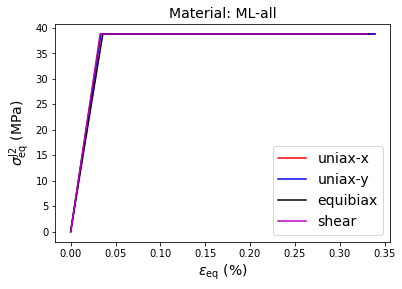



====== Texture Parameter 1.75 ======
Yield locus for microstructure with interpolated yield strength 45.7 MPa
Blue line: Yield locus of isotropic J2 material with yield strength 44.75 MPa


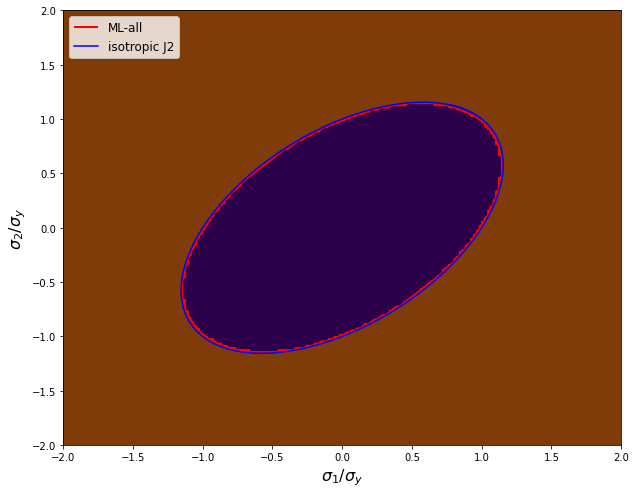

Stress-Strain-Curves
---------------------------------------------------------
J2 yield stress under uniax-x loading: 44.231 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 44.228 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 44.231 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 44.213 MPa
---------------------------------------------------------


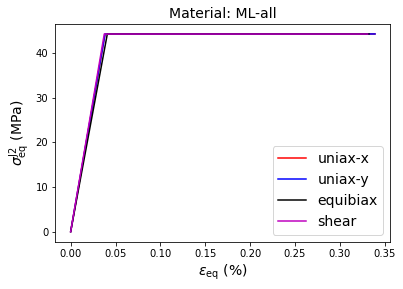



====== Texture Parameter 2.5 ======
Yield locus for microstructure with interpolated yield strength 45.7 MPa
Blue line: Yield locus of isotropic J2 material with yield strength 44.75 MPa


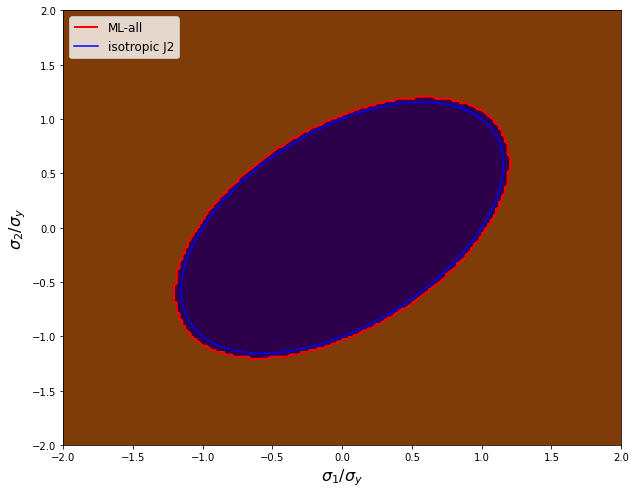

Stress-Strain-Curves
---------------------------------------------------------
J2 yield stress under uniax-x loading: 46.452 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 46.452 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 46.452 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 46.459 MPa
---------------------------------------------------------


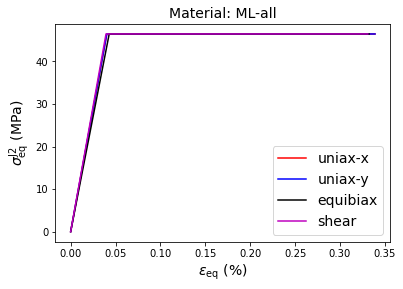



====== Texture Parameter 3.25 ======
Yield locus for microstructure with interpolated yield strength 45.83 MPa
Blue line: Yield locus of isotropic J2 material with yield strength 44.75 MPa


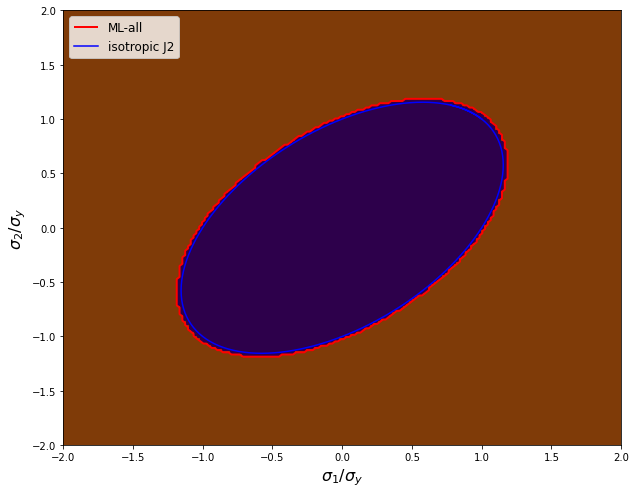

Stress-Strain-Curves
---------------------------------------------------------
J2 yield stress under uniax-x loading: 45.971 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 45.972 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 45.971 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 45.969 MPa
---------------------------------------------------------


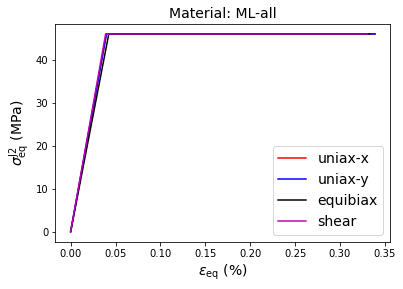



====== Texture Parameter 4.0 ======
Yield locus for microstructure with interpolated yield strength 48.63 MPa
Blue line: Yield locus of isotropic J2 material with yield strength 44.75 MPa


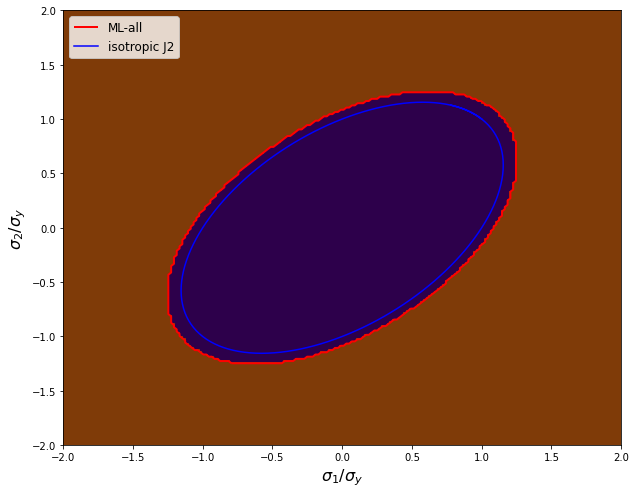

Stress-Strain-Curves
---------------------------------------------------------
J2 yield stress under uniax-x loading: 48.642 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 48.642 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 48.642 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 48.642 MPa
---------------------------------------------------------


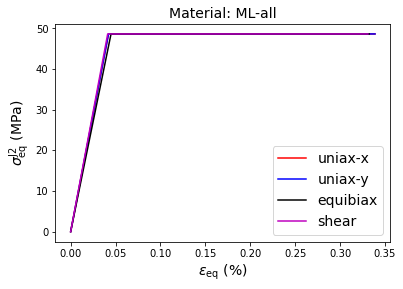

In [24]:
Npl = 5 # number of test cases
peeq = mat_ml.msparam['work_hard'][0] - mat_ml.msparam['epc']
for i in range(Npl):
    tp = 1. + i*(data.Nset-1)/(Npl-1) # arbitrary texture parameter covers range [1,Nset]
    mat_ml.set_microstructure('texture', tp)
    mat_ml.set_workhard(peeq)
    print('\n\n====== Texture Parameter',tp,'======')
    print('Yield locus for microstructure with interpolated yield strength', mat_ml.sflow.round(decimals=2),'MPa')
    print('Blue line: Yield locus of isotropic J2 material with yield strength', mat_ml.sy.round(decimals=2),'MPa')
    mat_ml.plot_yield_locus(field=True, iso=True, Nmesh=200)
    plt.show()
    print('Stress-Strain-Curves')
    mat_ml.calc_properties(verb=False, eps=0.003, sigeps=True)
    mat_ml.plot_stress_strain()
